##### Try DBSCAN with data by 
* Imputing missing data with mode()
* MinMax Scaler

In [ ]:
# Third-party Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import plotly.express as px

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from ydata_profiling import ProfileReport  # Quick EDA

# Local imports
from src.utils import count_plot_percentage, one_hot_encoding

In [2]:
data_fill_null_mode = pd.read_csv("data/Citywide_Mobility_Survey_-_Person_Survey_2019.csv")

In [3]:
data_fill_null_mode.shape

(8286, 165)

In [4]:
data_fill_null_mode.drop(['person_num','relationship'],axis=1,inplace=True)

In [5]:
data_fill_null_mode.drop(['hh_id','person_id','weight','first_travel_date','last_travel_date','num_days','num_days_complete'],axis=1, inplace=True)

In [6]:
data_fill_null_mode.shape

(8286, 156)

# Missing Values

convert the -9998 value to NaN to handle it also with missing values

In [7]:
for column in data_fill_null_mode.columns:
    data_fill_null_mode[column] = data_fill_null_mode[column].replace(-9998,np.nan)
    data_fill_null_mode[column] = data_fill_null_mode[column].replace("-9998",np.nan)

In [8]:
null_percentage = data_fill_null_mode.isna().mean().sort_values(ascending=False)[data_fill_null_mode.isna().sum()>0] 

In [9]:
null_percentage = data_fill_null_mode.isna().sum().\
    apply(lambda x:x/data_fill_null_mode.shape[0]*100).\
        sort_values(ascending=False)[data_fill_null_mode.isna().sum()>0] 

remove any column have more than 50% NULL

In [10]:
print(f"before Remove  {data_fill_null_mode.shape}")
data_fill_null_mode.drop(columns=null_percentage[null_percentage>50].index.to_list(),inplace=True)
print(f"after Remove  {data_fill_null_mode.shape}")


before Remove  (8286, 156)
after Remove  (8286, 137)


In [11]:
print(f"before Remove  {data_fill_null_mode.shape}")
data_fill_null_mode = data_fill_null_mode[data_fill_null_mode["is_participant"]==1]
print(f"after Remove  {data_fill_null_mode.shape}")

before Remove  (8286, 137)
after Remove  (3346, 137)


In [12]:
# Fill data having null percentage less than 50% with mode(), as most of the data are nominal
def fill_null_values(dataframe):
    for column in dataframe:
        dataframe[column].fillna(dataframe[column].mode()[0],inplace=True)
    return dataframe

In [13]:
data_fill_null_mode = fill_null_values(data_fill_null_mode)

In [14]:
print(f"after Remove  {data_fill_null_mode.shape}")

after Remove  (3346, 137)


# Encoding Features

In [15]:
with open("data/columns_encoding.json") as file:
    columns_dictionary = json.loads(file.read()) # read the file as string and convert it to dictionary

In [16]:
columns_dictionary

{'survey_mode': {'1': 'rMove',
  '2': 'rSurvey',
  '3': 'Call center',
  '995': 'skip logic'},
 'is_participant': {'0': 'Not selected', '1': 'Selected', '995': 'skip logic'},
 'made_trips': {'0': 'Not selected', '1': 'Selected', '995': 'skip logic'},
 'relationship': {'0': 'Self',
  '1': 'Spouse or partner',
  '2': 'Son or daughter',
  '3': 'Father or mother',
  '4': 'Brother or sister',
  '5': 'Other relative',
  '6': 'Roommate or friend',
  '7': 'Household help',
  '995': 'skip logic'},
 'age': {'1': 'Under 5',
  '2': '5-15',
  '3': '16-17',
  '4': '18-24',
  '5': '25-34',
  '6': '35-44',
  '7': '45-54',
  '8': '55-64',
  '9': '65-74',
  '10': '75-84',
  '11': '85 or older',
  '995': 'skip logic'},
 'employment': {'1': 'Employed full-time',
  '2': 'Employed part-time',
  '3': 'Primarily self-employed',
  '6': 'Not currently employed',
  '7': 'Unpaid volunteer or intern',
  '995': 'skip logic'},
 'worker': {'0': 'Not employed', '1': 'Employed', '995': 'skip logic'},
 'student': {'0': 

for each column_name in the dictionary encode the data using the dictionary values to create one_hot_encoding

In [17]:
#TODO: LabelEncoder for ordinal data, s.t. Age

In [18]:
#TODO: OHE 'cms_zone' feature

In [19]:
for column_name in columns_dictionary:
    data = one_hot_encoding(data=data_fill_null_mode,
                            column=column_name,
                            dictionary=columns_dictionary[column_name])

In [20]:
data_fill_null_mode.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [21]:
data_fill_null_mode.select_dtypes(include='object').columns # will handle it later

Index(['cms_zone', 'survey_mode', 'is_participant', 'age', 'employment',
       'worker', 'student', 'license', 'vehicle', 'congestion',
       ...
       'race_native_hawaiian', 'race_white', 'race_other',
       'disability_hearing', 'disability_seeing', 'disability_walking',
       'disability_mobility', 'disability_dressing',
       'disability_concentrating', 'disability_none'],
      dtype='object', length=134)

select numberic features only to apply kmeans on them

In [22]:
numeric_fetures = data_fill_null_mode.select_dtypes(include=np.number).columns.tolist()
data_numeric = data_fill_null_mode[numeric_fetures]
data_numeric.shape

(3346, 3)

##### Feature Scaling

select numberic features only to apply kmeans on them

In [23]:
numeric_fetures = data_fill_null_mode.select_dtypes(include=np.number).columns.tolist()
data_numeric = data_fill_null_mode[numeric_fetures]
data_numeric.shape

(3346, 3)

apply Standard Scaler on the Data

In [24]:
data_numeric_standarized = StandardScaler().fit_transform(data_numeric)
data_numeric_standarized = pd.DataFrame(data_numeric_standarized, columns = data_numeric.columns)
data_numeric_standarized.head()
# data_numeric_standarized = data_numeric

,smartphone_type,jobs_count,bike_num_days
0,-0.605829,1.549324,-1.267958
1,0.840037,-0.645878,-1.272097
2,0.840037,-0.645878,-1.272097
3,0.840037,-0.645878,0.786619
4,0.840037,-0.645878,-1.261751


In [25]:
from sklearn.preprocessing import MinMaxScaler

data_numeric_minmax = MinMaxScaler().fit_transform(data_numeric)
data_numeric_minmax = pd.DataFrame(data_numeric_minmax, columns = data_numeric.columns)
data_numeric_minmax.head()

,smartphone_type,jobs_count,bike_num_days
0,0.333333,1.0,0.002010
1,0.666667,0.0,0.000000
2,0.666667,0.0,0.000000
3,0.666667,0.0,1.000000
4,0.666667,0.0,0.005025


### DBSCAN
##### Hyperparamters used:
* "eps": specifies the maximum distance between two points to be considered neighbors and part of the same cluster                       
* "min_samples": specifies the minimum number of points required for a group of points to be considered a cluster
* "metric": clustering evaluation metric

##### Hyper Parameter Tuning

finding the optimal eps, and min_samples using silhouette_score

##### Choose hyperparameter 'eps' value using KNN

In [26]:
# transform dataframe into an array to include it as a parameter for KNN
array_data_numeric_minmax = np.array(data_numeric_minmax)
array_data_numeric_minmax

array([[0.33333333, 1.        , 0.00201005],
       [0.66666667, 0.        , 0.        ],
       [0.66666667, 0.        , 0.        ],
       ...,
       [1.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        ]])

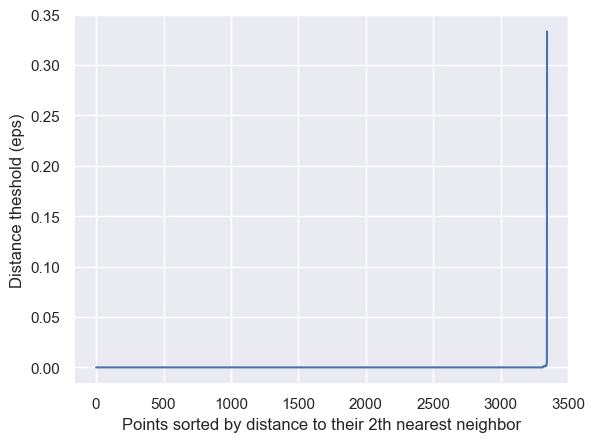

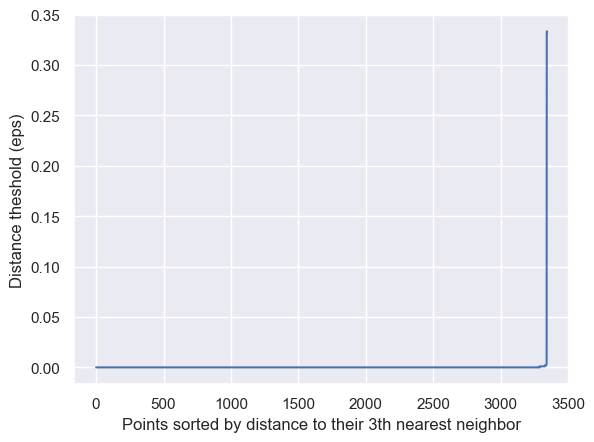

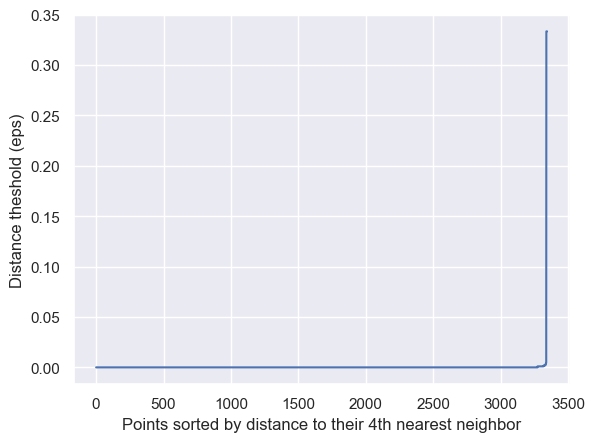

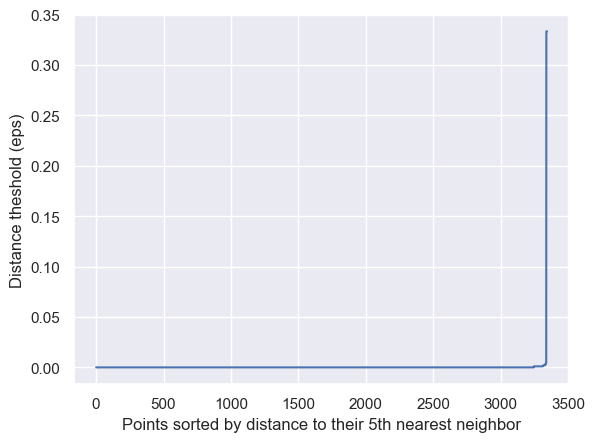

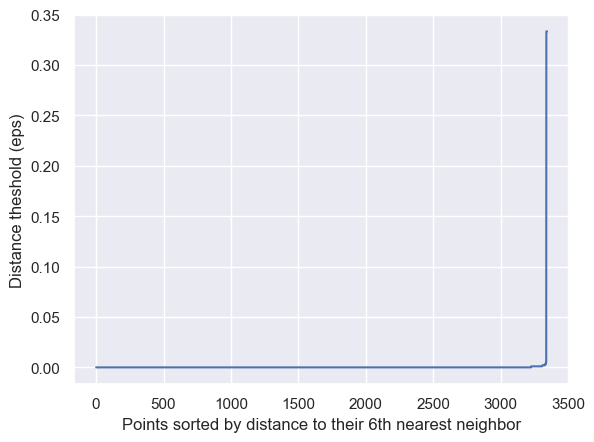

In [27]:
#  Determine the optimal 'eps' parameter by performing KNN trying multiple values for k
k_range = np.arange(2, 7)

for k in k_range:
    # Compute the distances to the kth nearest neighbor
    nearest_neighbors2 = NearestNeighbors(n_neighbors=k).fit(array_data_numeric_minmax)
    distances2, indices2 = nearest_neighbors2.kneighbors(array_data_numeric_minmax)
    k_distances2 = np.sort(distances2[:, -1])

    # Plot the sorted distances
    plt.plot(k_distances2)
    plt.xlabel(f'Points sorted by distance to their {k}th nearest neighbor')
    plt.ylabel('Distance theshold (eps)')
    plt.show()

##### set range of hyperparameters values to try

Best hyperparameters: eps=0.1, min_samples=2


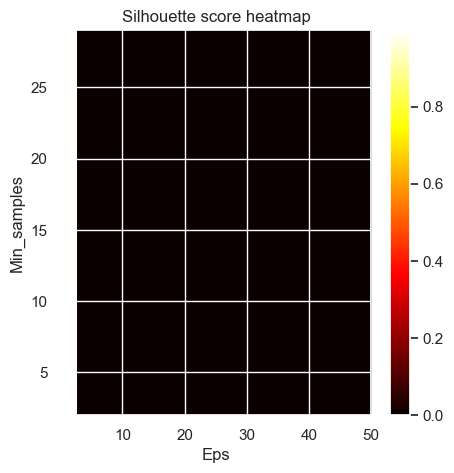

In [28]:
# set range of hyperparameter values to try
eps_range = np.linspace(0.1, 50.0, num=20)
min_samples_range = np.arange(2, 30)

# initialize array to store silhouette scores
silhouette_scores = np.zeros((len(eps_range), len(min_samples_range)))

# loop over hyperparameter values and calculate silhouette scores
for indx_eps, eps in enumerate(eps_range):
    for indx_min_samples, min_samples in enumerate(min_samples_range):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data_numeric_minmax)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            silhouette_scores[indx_eps, indx_min_samples] = \
            silhouette_score(data_numeric_minmax, labels, metric = 'euclidean')


# plot silhouette score heatmap
plt.figure(figsize=(5, 5))
plt.title("Silhouette score heatmap")
plt.xlabel("Eps")
plt.ylabel("Min_samples")
plt.imshow(silhouette_scores.T, cmap='hot', interpolation='nearest',
           extent=[eps_range[0], eps_range[-1], 
                   min_samples_range[0], min_samples_range[-1]],
           aspect='auto', origin='lower')
plt.colorbar()

# select best hyperparameters based on evaluation metrics
best_eps_idx, best_min_samples_idx = np.unravel_index(
    np.argmax(silhouette_scores), silhouette_scores.shape)
best_eps = eps_range[best_eps_idx]
best_min_samples = min_samples_range[best_min_samples_idx]
print(f"Best hyperparameters: eps={best_eps}, min_samples={best_min_samples}")

##### Create DBSCAN object with resulted best hyperparameters and observe its silhouette score

In [29]:
# Create DBSCAN object with resulted best hyperparameters
dbscan = DBSCAN(eps=best_eps, metric='euclidean', 
                min_samples=best_min_samples)

# Fit model and predict clusters
labels = dbscan.fit_predict(data_numeric_minmax)

# retrieve unique clusters
unique_labels = set(labels)
# get number of unique clusters
no_clusters = len(unique_labels)
# get number of noise
no_noise = np.sum(np.array(labels) == -1, axis=0)

print(f'unique_labels = {unique_labels}')
print(f'Number of clusters in DBSCAN = {no_clusters}')
print(f'Number of noise in DBSCAN = {no_noise}')

# Compute silhouette score
silhouette_avg = silhouette_score(data_numeric_minmax, labels)

# Print silhouette score
print("The average silhouette score for DBSCAN with eps=50 and min_samples=1 is:", silhouette_avg)

unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}
Number of clusters in DBSCAN = 16
Number of noise in DBSCAN = 1
The average silhouette score for DBSCAN with eps=50 and min_samples=1 is: 0.9981671028071536


In [30]:
# Extract the cluster centers
unique_labels = set(labels)
cluster_centers = []
for label in unique_labels:
    if label != -1:
        cluster_centers.append(data_numeric_minmax[labels == label].mean(axis=0))

# Print the number of clusters and their centers
n_clusters = len(cluster_centers)
print(f"Number of clusters found: {n_clusters}\n")
print("Cluster centers:")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i+1}:")
    print(f"{center}\n\n")

Number of clusters found: 15

Cluster centers:
Cluster 1:
smartphone_type    0.333333
jobs_count         1.000000
bike_num_days      0.000267
dtype: float64


Cluster 2:
smartphone_type    0.666667
jobs_count         0.000217
bike_num_days      0.000407
dtype: float64


Cluster 3:
smartphone_type    0.666667
jobs_count         0.000202
bike_num_days      1.000000
dtype: float64


Cluster 4:
smartphone_type    0.333333
jobs_count         0.000159
bike_num_days      1.000000
dtype: float64


Cluster 5:
smartphone_type    0.333333
jobs_count         1.000000
bike_num_days      1.000000
dtype: float64


Cluster 6:
smartphone_type    0.666667
jobs_count         1.000000
bike_num_days      1.000000
dtype: float64


Cluster 7:
smartphone_type    0.333333
jobs_count         0.000231
bike_num_days      0.000390
dtype: float64


Cluster 8:
smartphone_type    0.666667
jobs_count         1.000000
bike_num_days      0.000324
dtype: float64


Cluster 9:
smartphone_type    0.000000
jobs_count        

## PCA

In [31]:
pca_model2 = PCA(n_components = 2)
pca_model2.fit(data_numeric_minmax)

PCA(n_components=2)

In [32]:
training_data_pca2 = pca_model2.transform(data_numeric_minmax)
centers_pca2 = pca_model2.transform(cluster_centers)

d:\Data Mining\Data Mining Assignment1\DM-Assignment1-NYC-transportation\venv_DM_NYC\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [33]:
(training_data_pca2).shape

(3346, 2)

In [34]:
centers_pca2

array([[ 0.30200975,  0.89626717],
       [ 0.70015503, -0.06417879],
       [-0.22530432, -0.43623196],
       [-0.26476524, -0.39589662],
       [-0.62358438,  0.52417612],
       [-0.58410801,  0.48380119],
       [ 0.66068896, -0.02378495],
       [ 0.3414335 ,  0.85587108],
       [-0.30425457, -0.35548846],
       [-0.66306075,  0.56455106],
       [ 0.26190839,  0.93639086],
       [ 0.6208439 ,  0.01636937],
       [-0.54463165,  0.44342625],
       [-0.18575547, -0.47679276],
       [ 0.73636403, -0.10609852]])

In [35]:
pca_dataframe = pd.DataFrame(data=training_data_pca2,
                             columns=['pca1','pca2'])
pca_dataframe

,pca1,pca2
0,0.300396,0.895618
1,0.700610,-0.064227
2,0.700610,-0.064227
3,-0.225232,-0.436418
4,0.695957,-0.066098
...,...,...
3341,-0.304185,-0.355668
3342,-0.264708,-0.396043
3343,-0.185755,-0.476793
3344,-0.304185,-0.355668


In [36]:
pca_df = pd.concat([pca_dataframe, pd.DataFrame({'cluster': labels})], axis=1)
pca_df

,pca1,pca2,cluster
0,0.300396,0.895618,0
1,0.700610,-0.064227,1
2,0.700610,-0.064227,1
3,-0.225232,-0.436418,2
4,0.695957,-0.066098,1
...,...,...,...
3341,-0.304185,-0.355668,8
3342,-0.264708,-0.396043,3
3343,-0.185755,-0.476793,13
3344,-0.304185,-0.355668,8


In [37]:
type(labels)

numpy.ndarray

In [38]:
unique_vals, counts = np.unique(labels, return_counts=True)

In [39]:
for val, count in zip(unique_vals, counts):
    print(f"{val}: {count}")

-1: 1
0: 158
1: 588
2: 787
3: 538
4: 201
5: 220
6: 309
7: 152
8: 98
9: 210
10: 32
11: 37
12: 10
13: 3
14: 2


* We have 4 samples of cluster0
* Almost all the data considered as noise

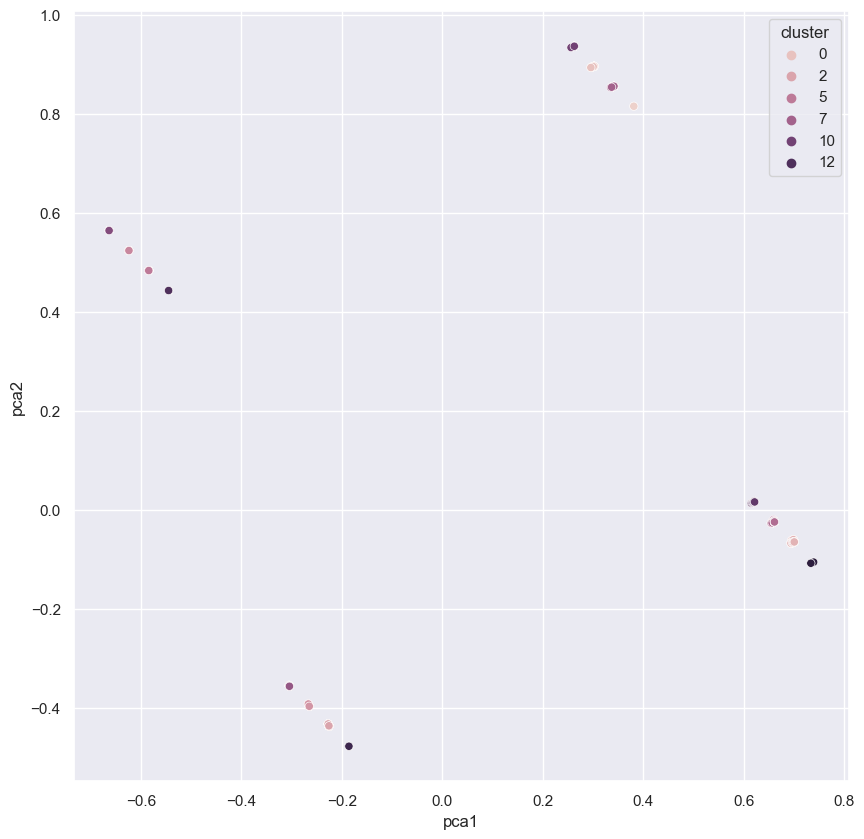

In [40]:
plt.figure(figsize=(10,10))
ax= sns.scatterplot(x="pca1", y="pca2", hue="cluster",data=pca_df, )
plt.show()

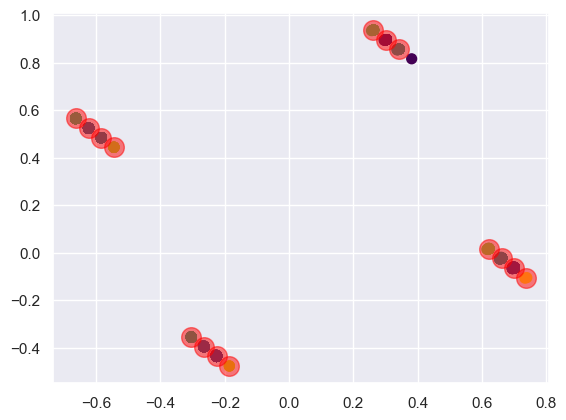

In [41]:
plt.scatter(training_data_pca2[:, 0],
            training_data_pca2[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers_pca2[:, 0], centers_pca2[:, 1], c='red', s=200, alpha=0.5)

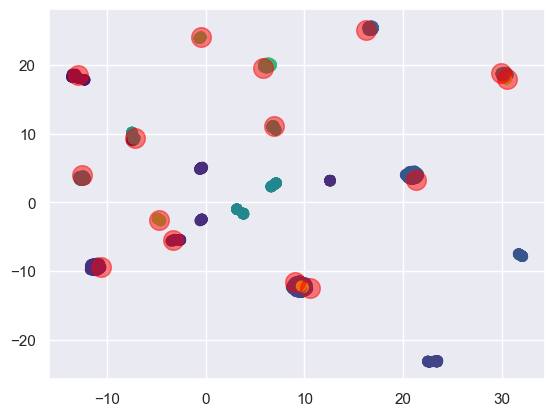

In [42]:
import umap.umap_ as umap
reducer = umap.UMAP(n_components=2)
umap_model = reducer.fit(data_numeric_minmax)
training_data_embedding = umap_model.transform(data_numeric_minmax)
centers_embedding = umap_model.transform(cluster_centers)

# plot the data in the low dim with the cluster results
plt.scatter(training_data_embedding[:, 0],
            training_data_embedding[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers_embedding[:, 0], centers_embedding[:, 1], c='red', s=200, alpha=0.5)
plt.show(block=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.92, '3D PCA plot')

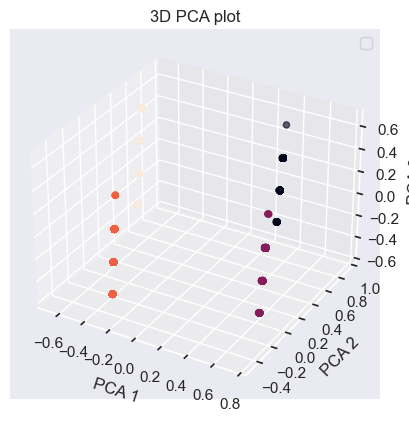

In [43]:
# pca 3D > then DBSCAN > then visualizatin
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# apply PCA to reduce the dimensions to 3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(data_numeric_minmax)

# apply DBSCAN clustering algorithm on the reduced data
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_pca)

# plot the clusters in a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=dbscan.labels_)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
# plt.show()
ax.legend()
plt.title("3D PCA plot")


[smartphone_type    0.333333
jobs_count         1.000000
bike_num_days      0.000267
dtype: float64, smartphone_type    0.666667
jobs_count         0.000217
bike_num_days      0.000407
dtype: float64, smartphone_type    0.666667
jobs_count         0.000202
bike_num_days      1.000000
dtype: float64, smartphone_type    0.333333
jobs_count         0.000159
bike_num_days      1.000000
dtype: float64, smartphone_type    0.333333
jobs_count         1.000000
bike_num_days      1.000000
dtype: float64, smartphone_type    0.666667
jobs_count         1.000000
bike_num_days      1.000000
dtype: float64, smartphone_type    0.333333
jobs_count         0.000231
bike_num_days      0.000390
dtype: float64, smartphone_type    0.666667
jobs_count         1.000000
bike_num_days      0.000324
dtype: float64, smartphone_type    0.000000
jobs_count         0.000195
bike_num_days      1.000000
dtype: float64, smartphone_type    0.0
jobs_count         1.0
bike_num_days      1.0
dtype: float64, smartphone_typ

d:\Data Mining\Data Mining Assignment1\DM-Assignment1-NYC-transportation\venv_DM_NYC\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


KeyError: 2

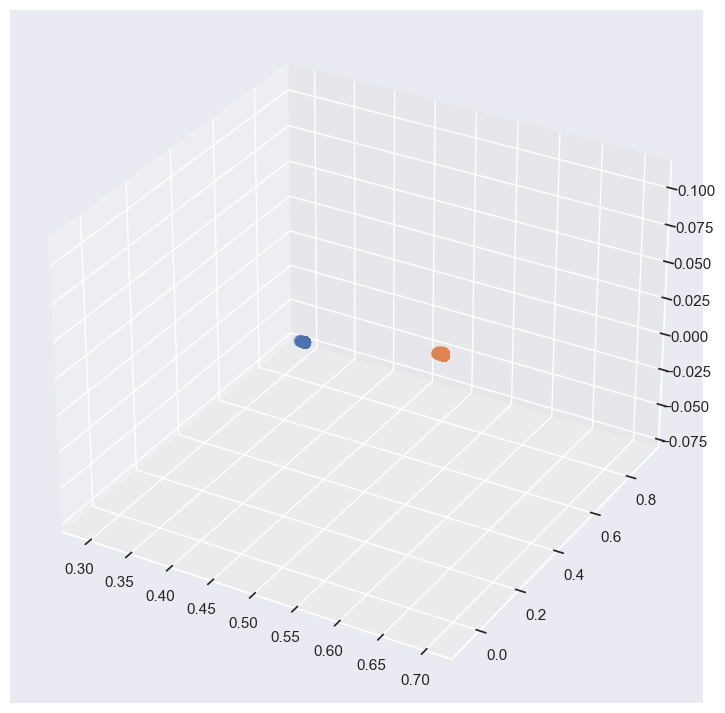

In [45]:
pca_3d_dbscan = PCA(n_components=3)
pca_3d_dbscan.fit(data_numeric_minmax)
pca_bcancer_dbscan = pca_3d_dbscan.transform(data_numeric_minmax)
pca_centers_dbscan = pca_3d_dbscan.transform(cluster_centers)
print(cluster_centers)
print(pca_centers_dbscan)
# map each cluster label to a specific color that will be used to plot the corresponding data points
cdict = {0:'m',1:'y'} # 'm' = magenta, 'c' = cyan
label = {0:'0',1:'1'}
y = labels

Xax = pca_bcancer_dbscan[:,0]
Yax = pca_bcancer_dbscan[:,1]
Zax = pca_bcancer_dbscan[:,2]

fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111, 
                     projection='3d')

for l in np.unique(y):
    if l != -1:
        ix = np.where(y == l)
        ax.scatter(Xax[ix], 
                   Yax[ix], 
                   Zax[ix], 
                #    c=cdict[l], 
                   s=60,
                   label=label[l]) 


ax.set_xlabel("PC1", 
              fontsize=12)
ax.set_ylabel("PC2", 
              fontsize=12)
ax.set_zlabel("PC3", 
              fontsize=12)
 
ax.view_init(30, 125)
ax.legend()
plt.title("3D PCA plot")